# Install Packages

!pip install cairocffi

In [23]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import seaborn as sns
sns.set() 

# Functions

In [2]:
def train_remake(array):
    res = []
    for row in array:
        res += [row]
    return res

# Import Data

In [3]:
classes = ['face','eye','mouth','nose','ear']
class_mapping = {'face': 0, 'ear': 1,'eye': 2,'mouth': 3,'nose': 4}
#countries = ['AU','RU','BR','KR','SA']#'TW','HK','JP'
#countries = ['AU','KR','SA']
#countries_mapping = {'AU': 0,'RU': 1,'BR': 2,'KR': 3,'SA': 4}
#countries_mapping = {'AU': 0,'KR': 1,'SA': 2}
# classes = ['eye','mouth','nose','ear']
# classes = ['eye','mouth']

In [4]:
all_files = glob.glob(os.path.join('data', '*.bin'))
image_size = 125

## import binary data

In [5]:
import numpy as np
import cairocffi as cairo

def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        bbox = np.hstack(vector_image).max(axis=1)#1
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [6]:
import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    # word, = unpack('s', file_handle.read(2))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    # temp = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = list(unpack(fmt, file_handle.read(n_points)))
        y = list(unpack(fmt, file_handle.read(n_points)))
        # temp += [[x,y]]
        image.append((x, y))
    #     print(n_strokes)
    # temp = vector_to_raster(n_strokes)
    
    # image.append(temp)
        

    return {
        # 'word': word,
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        # 'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

In [7]:
countrycode = []
recognized = []
word = []
image = []
stroke = []
# image = np.empty([0,28*28])
for i in all_files:
    for drawing in unpack_drawings(i):
        #if (drawing['recognized'] == 1)  :
        word += [re.findall(r'[a-z]+',i)[1]]
        countrycode += re.findall(r'[A-Z][A-Z]',str(drawing['countrycode']))
        stroke += [drawing['image']]
        image += vector_to_raster([drawing['image']],side = image_size )
        recognized += [drawing['recognized']]
        #else :
        #    continue
      
      # word += [re.findall(r'[a-z]+',i)[1]]
      # countrycode += re.findall(r'[A-Z][A-Z]',str(drawing['countrycode']))
      # recognized += [drawing['recognized']]
      # # image += vector_to_raster([drawing['image']])
      # # image = np.concatenate((image,vector_to_raster([drawing['image']])),axis=0)

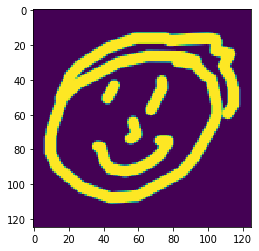

In [9]:
%matplotlib inline

idx = randint(0, len(image))
plt.imshow(np.array(image[idx]).reshape(image_size,image_size)) 
    # print(class_names[int(y[idx].item())])

# dataframe

In [10]:
stroke_count = []
stroke_info = {}

for i in range(len(stroke)):
    #stroke_count.append(len(stroke[i]))
    stroke_info[i] = {}
    stroke_info[i]['each_length'] = []
    for j in range(len(stroke[i])):
        stroke_info[i]['each_length'].append(len(stroke[i][j][0]))
    stroke_info[i]['count'] = len(stroke_info[i]['each_length'])
    stroke_info[i]['min'] = min(stroke_info[i]['each_length'])
    stroke_info[i]['max'] = max(stroke_info[i]['each_length'])
    stroke_info[i]['mean'] = np.mean(np.array(stroke_info[i]['each_length']))
    stroke_info[i]['median'] = np.median(np.array(stroke_info[i]['each_length']))

In [11]:
df_stroke = pd.DataFrame.from_dict(stroke_info,orient='index')
df_stroke = df_stroke.reset_index()
df_stroke = df_stroke.rename(columns={'index':'id'})
df_stroke

,id,each_length,count,min,max,mean,median
0,0,"[23, 2]",2,2,23,12.500000,12.5
1,1,"[16, 16, 19]",3,16,19,17.000000,16.0
2,2,"[7, 6, 6]",3,6,7,6.333333,6.0
3,3,"[10, 7]",2,7,10,8.500000,8.5
4,4,"[3, 27, 9]",3,3,27,13.000000,9.0
...,...,...,...,...,...,...,...
742154,742154,"[13, 5, 5, 6, 3, 3, 4]",7,3,13,5.571429,5.0
742155,742155,"[17, 17, 3, 2, 2]",5,2,17,8.200000,3.0
742156,742156,"[10, 11, 5, 4, 2, 2, 3, 2, 123]",9,2,123,18.000000,4.0
742157,742157,"[8, 10, 2, 6, 3, 3, 8]",7,2,10,5.714286,6.0


In [12]:
df = pd.DataFrame(list(zip(word, countrycode, recognized, image, stroke)), 
                  columns=['word', 'countrycode','recognized', 'image' ,'stroke']) 
df = df.reset_index()
df = df.rename(columns={'index':'id'})
df

,id,word,countrycode,recognized,image,stroke
0,0,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([88, 86, 82, 70, 56, 30, 9, 2, 0, 14, 46, 15..."
1,1,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([114, 63, 13, 0, 110, 150, 166, 182, 189, 19..."
2,2,nose,US,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([54, 50, 54, 52, 45, 30, 14], [3, 7, 39, 106..."
3,3,nose,NL,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([133, 135, 131, 72, 17, 2, 1, 13, 61, 177], ..."
4,4,nose,US,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 2, 9], [243, 175, 142]), ([11, 11, 17, 4..."
...,...,...,...,...,...,...
742154,742154,eye,US,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 34, 56, 96, 220, 238, 254, 255, 248, 244..."
742155,742155,eye,TH,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 40, 68, 93, 124, 151, 180, 222, 222, 180..."
742156,742156,eye,HU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 2, 20, 44, 60, 97, 115, 182, 212, 234], ..."
742157,742157,eye,TN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 14, 31, 61, 186, 213, 224, 224], [82, 54..."


In [13]:
ppt =df[df['countrycode'].isin(['AU','BR','KR','SA']) & df['recognized']==1][df['word']=='face'].groupby('countrycode').head(5)

//anaconda3/envs/envTF20/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [14]:
ppt

,id,word,countrycode,recognized,image,stroke
197592,197592,face,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([158, 57, 44, 35, 19, 8, 0, 0, 3, 14, 23, 44..."
197597,197597,face,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([155, 106, 83, 58, 43, 15, 1, 0, 3, 12, 19, ..."
197600,197600,face,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([63, 44, 24, 13, 10, 13, 26, 37, 64, 85, 109..."
197610,197610,face,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([78, 67, 66, 69, 82, 95, 99, 98, 88, 82, 76]..."
197646,197646,face,BR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([43, 27, 15, 6, 0, 0, 8, 17, 33, 46, 72, 104..."
197647,197647,face,BR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([62, 55, 62, 71, 82, 82, 70, 57], [76, 106, ..."
197648,197648,face,SA,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([11, 1, 0, 11, 32, 57, 83, 110, 123, 136, 14..."
197654,197654,face,BR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([19, 13, 10, 16, 58, 125, 160, 184, 198, 215..."
197657,197657,face,KR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([33, 17, 4, 1, 0, 10, 23, 39, 100, 166, 219,..."
197666,197666,face,SA,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([169, 154, 53, 32, 14, 1, 0, 9, 33, 52, 76, ..."


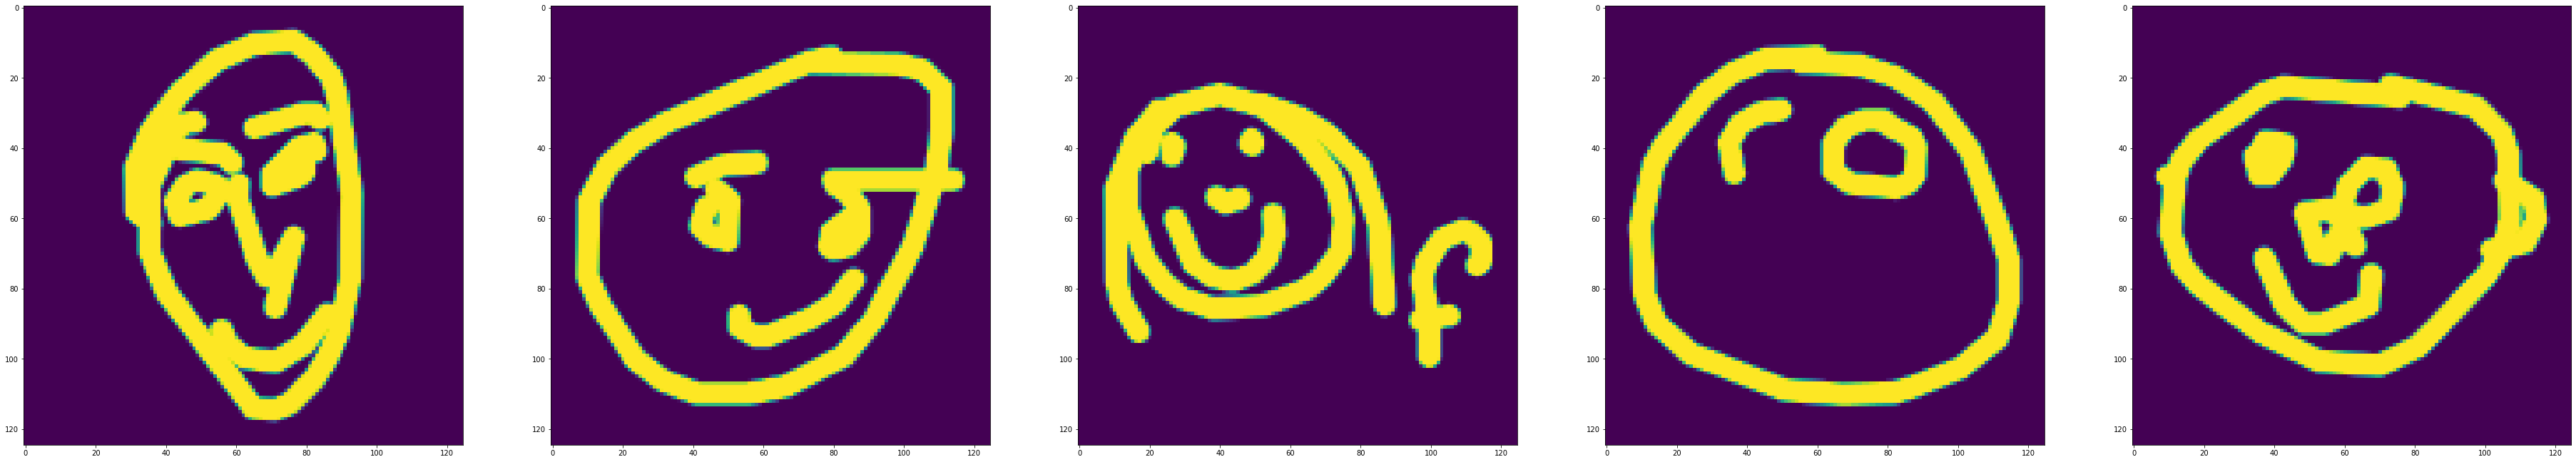

In [15]:
w=10
h=10
fig=plt.figure(figsize=(64, 30))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.array(ppt[ppt['countrycode']=='SA']['image'])[i-1].reshape(image_size,image_size))
plt.show()

In [16]:
len(df['countrycode'].unique())

202

In [17]:
rg = df[['word','recognized','id']].groupby(['word','recognized']).count()
rg = rg.reset_index()
rg

,word,recognized,id
0,ear,0,6086
1,ear,1,116811
2,eye,0,4858
3,eye,1,121030
4,face,0,13230
5,face,1,148436
6,mouth,0,8102
7,mouth,1,126033
8,nose,0,15096
9,nose,1,182477


Text(0, 0.5, 'count')

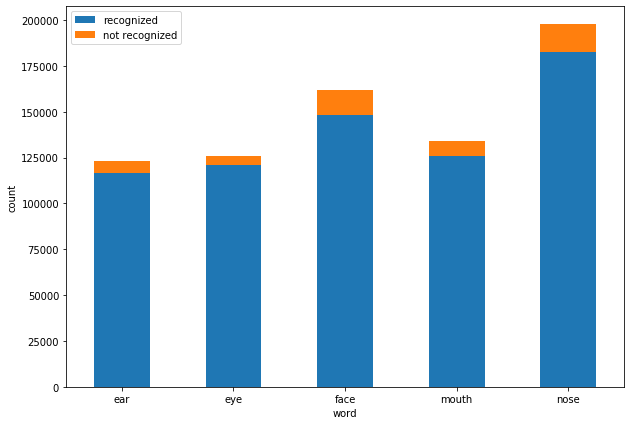

In [18]:
pivot_df = rg.pivot(index='word', columns='recognized', values='id')
pivot_df.columns = ['not recognized','recognized']
pivot_df.loc[:,['recognized','not recognized']].plot.bar(stacked=True, figsize=(10,7), rot=0)
plt.ylabel('count')

Text(0, 0.5, 'count')

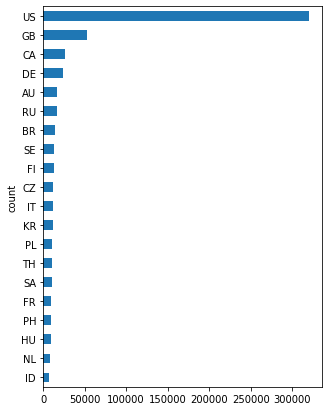

In [19]:

df_rg = df[df['recognized'] == 1]
ctr = df[['countrycode','id']].groupby(['countrycode']).count()
ctr = ctr.reset_index()
ctr.columns = ['countrycode','count']
a = ctr.sort_values(by='count',ascending=False).iloc[:20].set_index('countrycode').sort_values(by='count',ascending=True)

a.plot.barh(stacked=False, rot=0,legend=False, figsize=(5,7))
plt.ylabel('count')

In [107]:
#pivot_df = ctr.pivot(index='word', columns='countrycode', values='id')
#pivot_df.loc[:,].plot.bar(stacked=True, figsize=(10,7), rot=0)

In [20]:
df_raw = df.merge(df_stroke, how='left', left_on='id', right_on='id')
df_raw

,id,word,countrycode,recognized,image,stroke,each_length,count,min,max,mean,median
0,0,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([88, 86, 82, 70, 56, 30, 9, 2, 0, 14, 46, 15...","[23, 2]",2,2,23,12.500000,12.5
1,1,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([114, 63, 13, 0, 110, 150, 166, 182, 189, 19...","[16, 16, 19]",3,16,19,17.000000,16.0
2,2,nose,US,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([54, 50, 54, 52, 45, 30, 14], [3, 7, 39, 106...","[7, 6, 6]",3,6,7,6.333333,6.0
3,3,nose,NL,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([133, 135, 131, 72, 17, 2, 1, 13, 61, 177], ...","[10, 7]",2,7,10,8.500000,8.5
4,4,nose,US,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 2, 9], [243, 175, 142]), ([11, 11, 17, 4...","[3, 27, 9]",3,3,27,13.000000,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
742154,742154,eye,US,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 34, 56, 96, 220, 238, 254, 255, 248, 244...","[13, 5, 5, 6, 3, 3, 4]",7,3,13,5.571429,5.0
742155,742155,eye,TH,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 40, 68, 93, 124, 151, 180, 222, 222, 180...","[17, 17, 3, 2, 2]",5,2,17,8.200000,3.0
742156,742156,eye,HU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 2, 20, 44, 60, 97, 115, 182, 212, 234], ...","[10, 11, 5, 4, 2, 2, 3, 2, 123]",9,2,123,18.000000,4.0
742157,742157,eye,TN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 14, 31, 61, 186, 213, 224, 224], [82, 54...","[8, 10, 2, 6, 3, 3, 8]",7,2,10,5.714286,6.0


In [21]:
df_raw[['word','count']].groupby('word').mean()

,count
word,
ear,2.436284
eye,5.316122
face,6.580215
mouth,4.428770
nose,2.308549


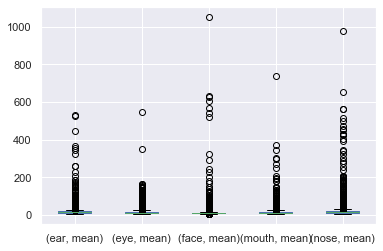

In [24]:
df_raw[['word','mean']].groupby('word').boxplot(subplots=False)

word
ear      [[AxesSubplot(0.125,0.125;0.775x0.755)]]
eye      [[AxesSubplot(0.125,0.125;0.775x0.755)]]
face     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
mouth    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
nose     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

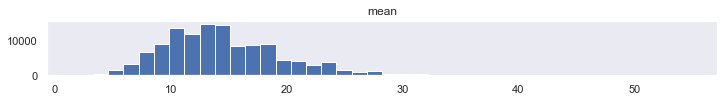

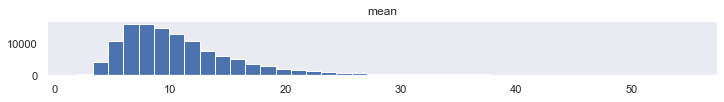

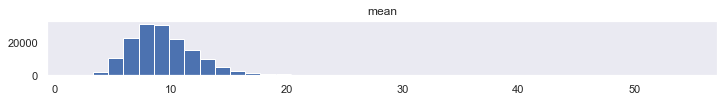

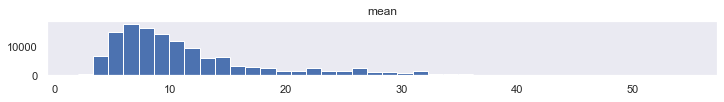

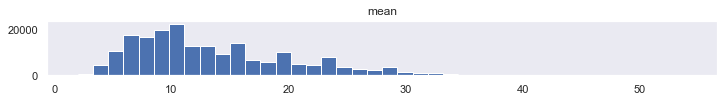

In [26]:
df_raw[df_raw['mean']<55][['word','mean']].groupby('word').hist(bins=40,grid=False,figsize=(12,1),sharex=True)

In [27]:
np.array(df_raw.iloc[0]['stroke'])

array([[list([88, 86, 82, 70, 56, 30, 9, 2, 0, 14, 46, 152, 190, 225, 242, 254, 255, 251, 203, 188, 181, 173, 175]),
        list([1, 66, 82, 98, 106, 113, 126, 139, 165, 178, 188, 190, 183, 170, 153, 126, 103, 96, 76, 66, 56, 36, 0])],
       [list([48, 50]), list([174, 169])]], dtype=object)

In [28]:
class_mapping = {'face': 0, 'ear': 1,'eye': 2,'mouth': 3,'nose': 4}
df_raw['word_label'] = [class_mapping[x] for x in df_raw['word']]

In [29]:
#df_raw.to_csv('df_all.csv')

In [30]:
c = df_raw.groupby(['countrycode'])['id'].count() > 1000
c_filter = pd.DataFrame(c)
c_filter = c_filter[c_filter['id']==True].index
c_filter

Index(['AE', 'AR', 'AT', 'AU', 'BA', 'BE', 'BG', 'BR', 'CA', 'CH', 'CO', 'CZ',
       'DE', 'DK', 'DZ', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HK', 'HR',
       'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IT', 'JP', 'KH', 'KR', 'KW', 'KZ',
       'LT', 'LV', 'MX', 'MY', 'NL', 'NO', 'NZ', 'PH', 'PL', 'PT', 'RO', 'RS',
       'RU', 'SA', 'SE', 'SG', 'SK', 'TH', 'TR', 'TW', 'UA', 'US', 'VN', 'ZA'],
      dtype='object', name='countrycode')

In [31]:
df_raw_filter = df_raw[df_raw['countrycode'].isin(c_filter)]

In [32]:
df_raw_filter[['id', 'word', 'countrycode', 'recognized', 'stroke',
       'each_length', 'count', 'min', 'max', 'mean', 'median', 'word_label']]

,id,word,countrycode,recognized,stroke,each_length,count,min,max,mean,median,word_label
0,0,nose,AU,1,"[([88, 86, 82, 70, 56, 30, 9, 2, 0, 14, 46, 15...","[23, 2]",2,2,23,12.500000,12.5,4
1,1,nose,AU,1,"[([114, 63, 13, 0, 110, 150, 166, 182, 189, 19...","[16, 16, 19]",3,16,19,17.000000,16.0,4
2,2,nose,US,1,"[([54, 50, 54, 52, 45, 30, 14], [3, 7, 39, 106...","[7, 6, 6]",3,6,7,6.333333,6.0,4
3,3,nose,NL,1,"[([133, 135, 131, 72, 17, 2, 1, 13, 61, 177], ...","[10, 7]",2,7,10,8.500000,8.5,4
4,4,nose,US,1,"[([0, 2, 9], [243, 175, 142]), ([11, 11, 17, 4...","[3, 27, 9]",3,3,27,13.000000,9.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
742153,742153,eye,IT,1,"[([104, 102, 90, 24, 22, 33, 53, 118, 142, 192...","[22, 23, 2, 2, 2, 2]",6,2,23,8.833333,2.0,2
742154,742154,eye,US,1,"[([0, 34, 56, 96, 220, 238, 254, 255, 248, 244...","[13, 5, 5, 6, 3, 3, 4]",7,3,13,5.571429,5.0,2
742155,742155,eye,TH,1,"[([0, 40, 68, 93, 124, 151, 180, 222, 222, 180...","[17, 17, 3, 2, 2]",5,2,17,8.200000,3.0,2
742156,742156,eye,HU,1,"[([0, 2, 20, 44, 60, 97, 115, 182, 212, 234], ...","[10, 11, 5, 4, 2, 2, 3, 2, 123]",9,2,123,18.000000,4.0,2


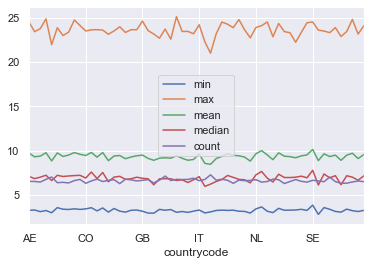

In [46]:
df_mean = df_raw_filter[df_raw_filter['word']=='face'].groupby(['countrycode']).mean()
df_mean[['min','max','mean','median','count']].plot()

In [121]:
df_mean['count'].mean()

6.634779689192789

In [25]:
df.groupby(['word']).count()

,id,countrycode,recognized
word,,,
circle,122876,122876,122876
ear,122897,122897,122897
eye,125888,125888,125888
face,161666,161666,161666
mouth,134135,134135,134135
nose,197573,197573,197573


## Average Doodle for recognized

In [231]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
cls = ['face','eye','mouth','nose','ear']

In [46]:
ys = []
for c in cls:
    x = np.array(image[0]).reshape(image_size,image_size)
    y = np.zeros(x.shape)
    count = 0
    for i in range(len(image)):
        if word[i] == c: #count<1000 and and countrycode[i] == 'AU':
            y += np.array(image[i]).reshape(image_size,image_size)
            count+=1
    y1 = y / count
    ys.append(y1) 

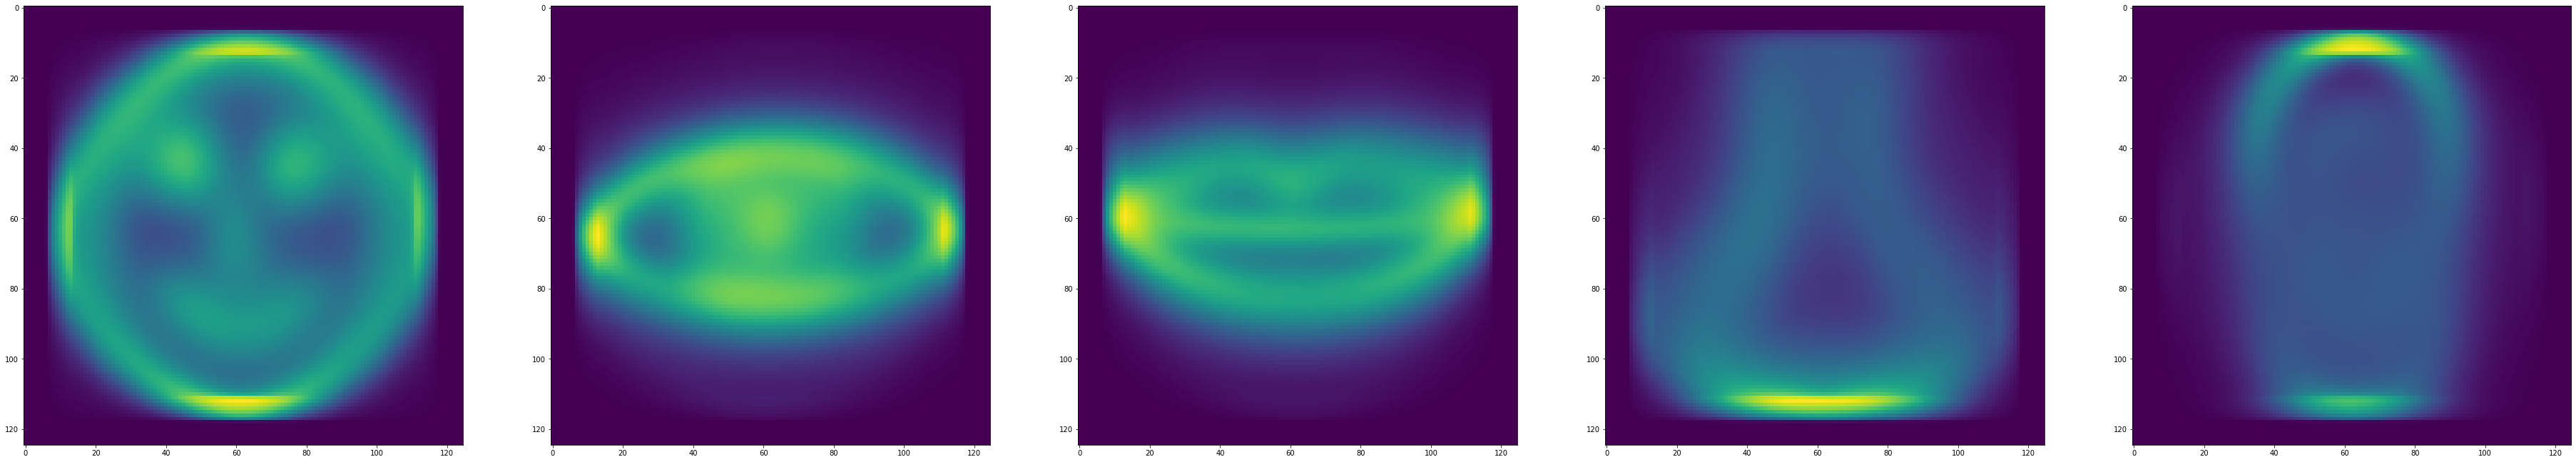

In [43]:
w=10
h=10
fig=plt.figure(figsize=(64, 30))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(ys[i-1])
plt.show()

In [48]:
tmp = []
ct = []
#countries = ['RU','AU','KR','AU','GB','BR','SE','FI','CZ']
#countries = ['US','GB','CA','DE','RU','AU','BR','SE','FI','CZ','IT','KR','SA','PL','FR']
countries = ['RU','AU','BR','SE','FI','CZ','IT','KR','SA','PL','FR']
countries_mapping = {'RU':0,'AU':1,'BR':2,'SE':3,'FI':4,'CZ':5,'IT':6,'KR':7,'SA':8,'PL':9,'FR':10}

for c in cls:
    for t in countries:
        x = np.array(image[0]).reshape(image_size,image_size)
        y = np.zeros(x.shape)
        count = 0
        count_total = 0
        for i in range(len(image)):
            if word[i] == c and countrycode[i] == t: #count < 1410 and 
                y += np.array(image[i]).reshape(image_size,image_size)
                count+=1
        y1 = y / count
        ct.append(count)
        tmp.append(y1) 

In [49]:
np.array(ct).reshape(len(cls),len(countries))

array([[3911, 3614, 2965, 2865, 2797, 2691, 2646, 2320, 2316, 2301, 2198],
       [2837, 2849, 2233, 2270, 2103, 2169, 2017, 1907, 1762, 1868, 1718],
       [2768, 3090, 2690, 2422, 2349, 2293, 2337, 2118, 1874, 2127, 1949],
       [4487, 4499, 3550, 3276, 3383, 3167, 3156, 3276, 2986, 2764, 2652],
       [2726, 2732, 2455, 2034, 2042, 1892, 1852, 1964, 1612, 1667, 1555]])

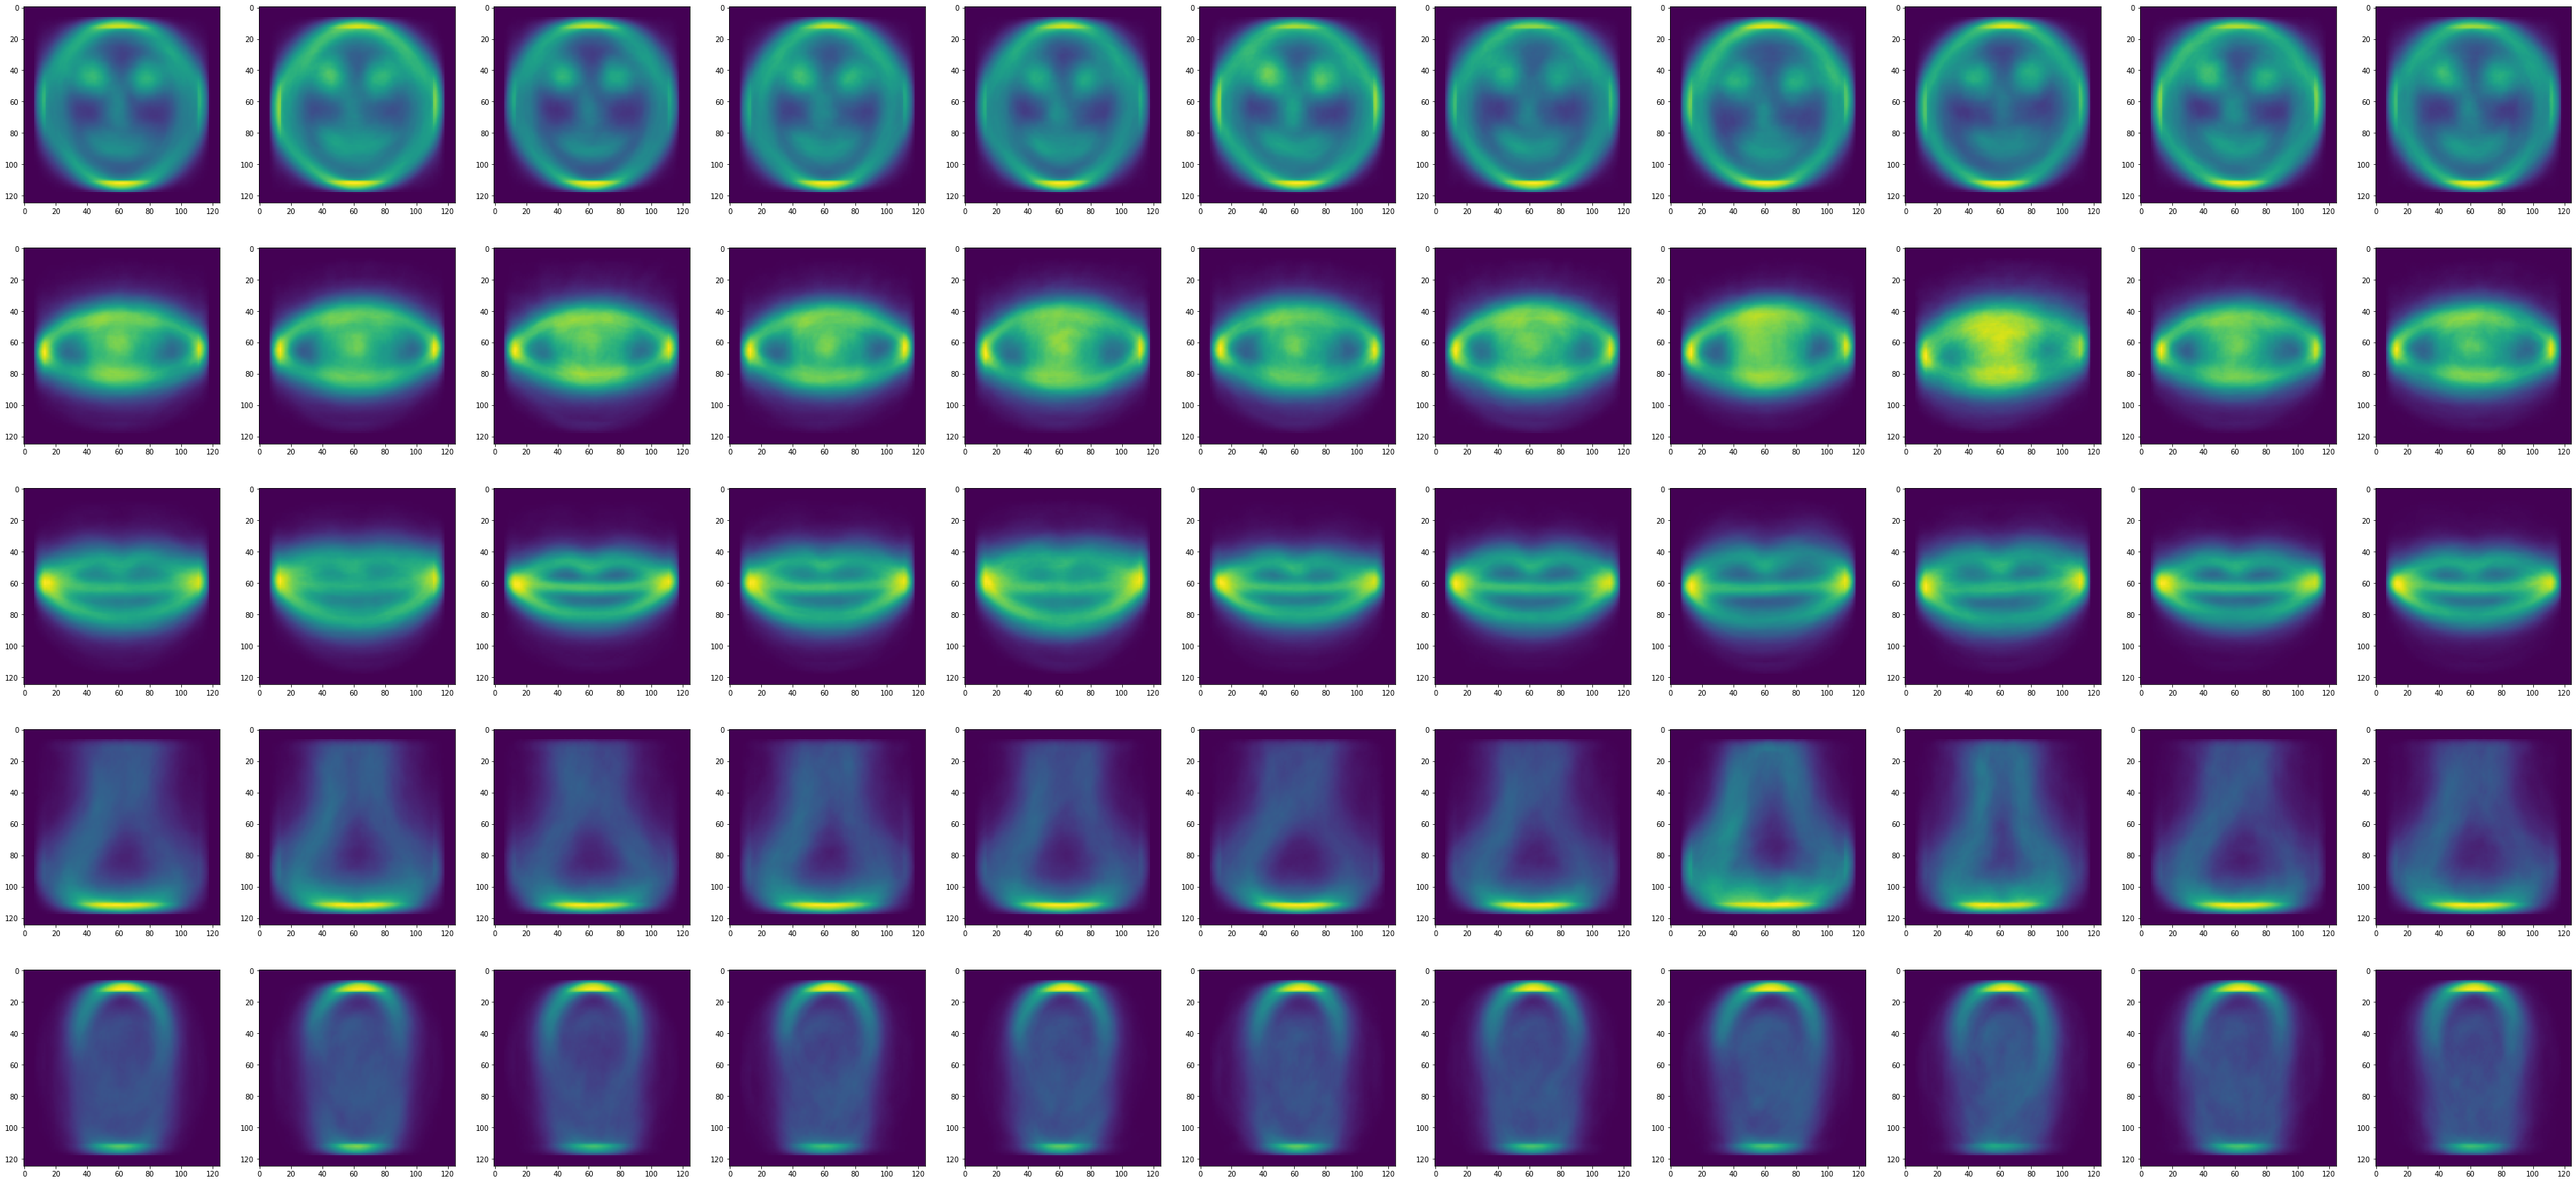

In [110]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(64,30))
columns = len(countries)
rows = len(cls)
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(tmp[i-1])
plt.show()

countries = ['RU','AU','BR','SE','FI','CZ','IT','KR','SA','PL','FR']

In [11]:
len(word)

813595

## t-SNE

### word

In [33]:
tsne = df_raw_filter.groupby('word').head(200)
tsne_100 = np.array(tsne['image'])
tsne_100 = np.vstack(tsne_100)
label = np.array(tsne['word_label'])

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(np.array(tsne_100))

In [35]:
result

array([[-1653.3156  ,   -25.013142],
       [  378.97723 ,   775.59    ],
       [-2475.7507  , -2370.21    ],
       ...,
       [-1228.1854  ,  -142.18895 ],
       [ 3228.266   ,  1334.8972  ],
       [ 5046.557   , -2298.1858  ]], dtype=float32)

In [36]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    num_class = len(np.unique(np.array(label)))

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.tab10(label[i] / num_class),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

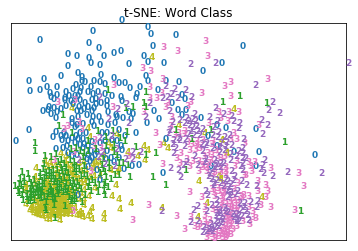

In [193]:
fig = plot_embedding(result, label, "t-SNE: Word Class")

### country

In [39]:
countries = ['RU','AU','BR','SE','FI','CZ','IT','KR','SA','PL','FR']
countries_mapping = {'RU':0,'AU':1,'BR':2,'SE':3,'FI':4,'CZ':5,'IT':6,'KR':7,'SA':8,'PL':9,'FR':10}

In [40]:
df_raw_11 = df_raw[df_raw['countrycode'].isin(countries)]
df_raw_11

,id,word,countrycode,recognized,image,stroke,each_length,count,min,max,mean,median,word_label
0,0,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([88, 86, 82, 70, 56, 30, 9, 2, 0, 14, 46, 15...","[23, 2]",2,2,23,12.500000,12.5,4
1,1,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([114, 63, 13, 0, 110, 150, 166, 182, 189, 19...","[16, 16, 19]",3,16,19,17.000000,16.0,4
11,11,nose,FI,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([41, 38, 1, 1, 6, 13, 29, 59, 93, 100, 118, ...",[19],1,19,19,19.000000,19.0,4
24,24,nose,FR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([90, 87, 76, 63, 35, 5, 0, 2, 14, 45, 77, 17...",[24],1,24,24,24.000000,24.0,4
27,27,nose,BR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([24, 36], [11, 48]), ([19, 31, 36, 36, 33, 1...","[2, 10, 10, 8]",4,2,10,7.500000,9.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
742145,742145,eye,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([20, 18, 23, 53, 82, 132, 194, 224, 248, 255...","[20, 33, 2, 2, 2, 2, 2]",7,2,33,9.000000,2.0,2
742147,742147,eye,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([167, 119, 65, 21, 0, 5, 27, 52, 77, 117, 13...","[21, 2, 11]",3,2,21,11.333333,11.0,2
742149,742149,eye,CZ,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([231, 202, 150, 77, 67, 39, 19, 10, 1, 1, 11...","[25, 14]",2,14,25,19.500000,19.5,2
742150,742150,eye,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([255, 230, 160, 109, 64, 44, 21], [42, 33, 1...","[7, 9, 4, 3, 2, 2, 2, 2, 3, 2, 3]",11,2,9,3.545455,3.0,2


In [41]:
df_raw_11['countrycode_label'] = [countries_mapping[x] for x in df_raw_11['countrycode']]

//anaconda3/envs/envTF20/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
tsne_11 = df_raw_11.groupby('countrycode').head(200)
tsne_100_c = np.array(tsne_11['image'])
tsne_100_c = np.vstack(tsne_100_c)
label_c = np.array(tsne_11['countrycode_label'])

In [48]:
tsne_c = TSNE(n_components=2, perplexity = 50, init='pca', random_state=0)
result_c = tsne_c.fit_transform(np.array(tsne_100_c))

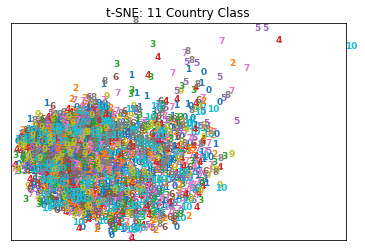

In [208]:
fig_c = plot_embedding(result_c, label_c, "t-SNE: 11 Country Class")

### 4 country

In [209]:
countries = ['AU','BR','KR','SA']
countries_mapping = {'AU':0,'BR':1,'KR':2, 'SA':3}

In [210]:
df_raw_4 = df_raw[df_raw['countrycode'].isin(countries)]
df_raw_4

,id,word,countrycode,recognized,image,stroke,each_length,count,min,max,mean,median,word_label
0,0,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([88, 86, 82, 70, 56, 30, 9, 2, 0, 14, 46, 15...","[23, 2]",2,2,23,12.500000,12.5,4
1,1,nose,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([114, 63, 13, 0, 110, 150, 166, 182, 189, 19...","[16, 16, 19]",3,16,19,17.000000,16.0,4
27,27,nose,BR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([24, 36], [11, 48]), ([19, 31, 36, 36, 33, 1...","[2, 10, 10, 8]",4,2,10,7.500000,9.0,4
31,31,nose,BR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([52, 46, 36, 32, 26], [0, 34, 144, 162, 171]...","[5, 8, 6]",3,5,8,6.333333,6.0,4
32,32,nose,KR,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([45, 50, 50, 61, 67, 41, 1, 0, 7, 40, 108, 1...",[20],1,20,20,20.000000,20.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
742106,742106,eye,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([13, 67, 110, 136, 159, 185, 209, 239], [28,...","[8, 9, 7]",3,7,9,8.000000,8.0,2
742116,742116,eye,SA,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([0, 42, 62, 82, 122, 255], [72, 26, 13, 6, 0...","[6, 2, 10, 16, 3]",5,2,16,7.400000,6.0,2
742145,742145,eye,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([20, 18, 23, 53, 82, 132, 194, 224, 248, 255...","[20, 33, 2, 2, 2, 2, 2]",7,2,33,9.000000,2.0,2
742147,742147,eye,AU,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[([167, 119, 65, 21, 0, 5, 27, 52, 77, 117, 13...","[21, 2, 11]",3,2,21,11.333333,11.0,2


In [211]:
df_raw_4['countrycode_label'] = [countries_mapping[x] for x in df_raw_4['countrycode']]

//anaconda3/envs/envTF20/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [212]:
tsne_4 = df_raw_4.groupby('countrycode').head(200)
tsne_100_c4 = np.array(tsne_4['image'])
tsne_100_c4 = np.vstack(tsne_100_c4)
label_c4 = np.array(tsne_4['countrycode_label'])

In [213]:
tsne_c4 = TSNE(n_components=2, init='pca', random_state=0)
result_c4 = tsne_c4.fit_transform(np.array(tsne_100_c4))

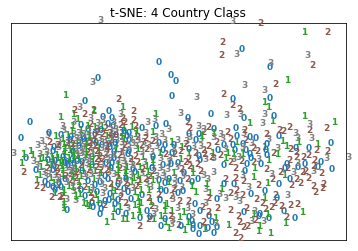

In [215]:
fig_c4 = plot_embedding(result_c4, label_c4, "t-SNE: 4 Country Class")